# CREATING ARTIFICIAL GALAXIES USING GANs.

#Mount Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#!pip install numpy matplotlib torch==1.7.0+cpu torchvision==0.8.1+cpu torchaudio==0.7.0 -f https://download.pytorch.org/whl/torch_stable.html


In [3]:
#!pip install numpy matplotlib torch==1.7.1+cu110 torchvision==0.8.2+cu110 torchaudio==0.7.2

# Load and import libraries

In [ ]:
import torch
import torch.nn as nn

from torch.autograd import Function
Function.apply



<function Function.apply>

In [ ]:
import os
import glob
import numpy as np
import pandas as pd
#%autoreload 2

import sys
import PIL
import logging

import pathlib
#import Swish from swish        
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as T
import matplotlib.pyplot as plt
%matplotlib inline
from IPython import display
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import *
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tqdm import tqdm

import torch.nn.functional as F
from torchvision.utils import save_image

#from keras.optimizers import *
from tensorflow.keras.layers import Conv2D, Conv2DTranspose,LeakyReLU, BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Softmax, Flatten,Dense, Reshape
from keras.layers import Activation, Dropout, ZeroPadding2D
from keras.layers.convolutional import UpSampling2D
from keras.backend import sigmoid
from keras.utils.generic_utils import get_custom_objects
from keras.utils import np_utils
from tqdm.notebook import tqdm


#supress all warnings
import warnings
warnings.filterwarnings("ignore")


#Load Data

In [ ]:
#Load files containing 50000 galaxy images

data_dir = "/content/drive/MyDrive/galax50k/"


In [ ]:
image_size = 64
batch_size = 128
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

In [ ]:
train_ds = ImageFolder(data_dir, transform=T.Compose([
    T.Resize(image_size),
    T.CenterCrop(image_size),
    T.ToTensor(),
    T.Normalize(*stats)]))

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)

In [ ]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

In [ ]:
import matplotlib.pyplot as plt
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    plt.figure(figsize=(12, 12))
    #ax = plt.subplot(4, 4, i + 1)
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

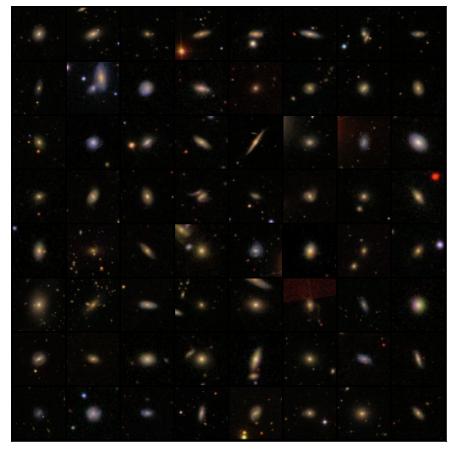

<Figure size 864x864 with 0 Axes>

In [ ]:
#Let us show a sample batch of real galaxy images. 
show_batch(train_dl)

# Using GPU

In [ ]:
#We set device selection to GPU
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
device = get_default_device()
device

device(type='cuda')

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)

#Discriminator Network

- The discriminator takes an image as input, and tries to classify it as "real" or "generated". In this sense, it's like any other neural network. We'll use a convolutional neural networks (CNN) which outputs a single number output for every image. We'll use stride of 2 to progressively reduce the size of the output feature map.

In [ ]:
discriminator = nn.Sequential(
    # in: 3 x 64 x 64

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid())

In [ ]:
discriminator = to_device(discriminator, device)

#Generator Network

- The input to the generator is typically a vector or a matrix of random numbers (referred to as a latent tensor) which is used as a seed for generating an image. The generator will convert a latent tensor of shape (128, 128, 3) into an image tensor of shape (3 x 64 x 64). To achieve this, we'll use the ConvTranspose2d layer from PyTorch, which functions as a transposed convolution (also referred to as a deconvolution)

In [ ]:
latent_size = 128

In [ ]:
generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False), 
    nn.Tanh()
    # out: 3 x 64 x 64
)

torch.Size([128, 3, 64, 64])


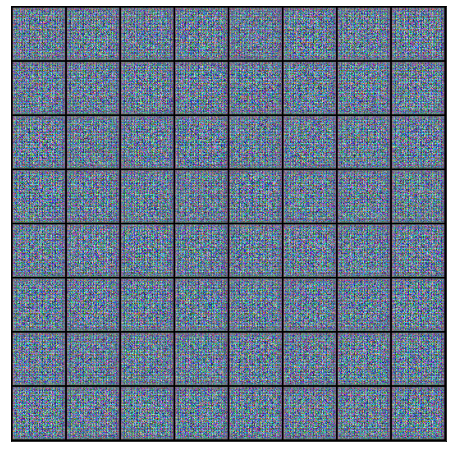

<Figure size 864x864 with 0 Axes>

In [ ]:
xb = torch.randn(batch_size, latent_size, 1, 1) # random latent tensors
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)

- As expected, the output from the generator is basically random noise, since we haven't trained it yet.
  Let's move the generator to the chosen device.

In [ ]:
generator = to_device(generator, device)

# Discriminator Training

- Since the discriminator is a binary classification model, we can use the binary cross entropy loss function to quantify how well it is able to differentiate between real and generated images.



In [ ]:
def train_discriminator(real_images, opt_d):
    # Clear discriminator gradients
    opt_d.zero_grad()

    # Pass real images through discriminator
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Pass fake images through discriminator
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    # Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(), real_score, fake_score

- Here are the steps involved in training the discriminator.

- We expect the discriminator to output 1 if the image was picked from the real galaxy dataset, and 0 if it was generated using the generator network.

- We first pass a batch of real images, and compute the loss, setting the target labels to 1.

- Then we pass a batch of fake images (generated using the generator) pass them into the discriminator, and compute the loss, setting the target labels to 0.

- Finally we add the two losses and use the overall loss to perform gradient descent to adjust the weights of the discriminator.

- It's important to note that we don't change the weights of the generator model while training the discriminator.

# Generator Training

- Since the outputs of the generator are images, it's not obvious how we can train the generator.
  This is where we employ a rather elegant trick, which is to use the discriminator as a part of the loss function. Here's how it works:

- We generate a batch of images using the generator, pass the into the discriminator.

- We calculate the loss by setting the target labels to 1 i.e. real. We do this because the generator's objective is to "fool" the discriminator.

- We use the loss to perform gradient descent i.e. change the weights of the generator, so it gets better at generating real-like images to "fool" the discriminator.

In [ ]:
def train_generator(opt_g):
    # Clear generator gradients
    opt_g.zero_grad()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)
    
    # Try to fool the discriminator
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)
    
    # Update generator weights
    loss.backward()
    opt_g.step()
    
    return loss.item()

- Let's create a directory where we can save intermediate outputs from the generator to visually inspect the progress of the model.
  We'll also create a helper function to export the generated images.

In [ ]:
generated_dir = "/content/drive/MyDrive/genrated"

In [ ]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    #fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    for i in range(len(fake_images)):
        img = fake_images[i]

        save_image(denorm(img), os.path.join(generated_dir, "fake_image_" + str(i)), nrow=8)
        print('Saving', "fake_image_" + i)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

- We'll use a fixed set of input vectors to the generator to see how the individual generated images evolve over time as we train the model. 
  Let's save one set of images before we start training our model.

In [ ]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

# Full Training Loop

- First we create the path to save individual samples of Real galaxy images and fake galaxy images.

In [ ]:
import cv2
realImage_dir = "/content/drive/MyDrive/RealImages"
fakeImage_dir = "/content/drive/MyDrive/genrated"


def saveRealAndFakeImages(real_images, latent_tensors, epoch_index):
    img_index = 1
    
    fake_images = generator(latent_tensors)
    for real, fake in zip(real_images, fake_images):
        if epoch_index == 149:
            
            save_image(denorm(real), os.path.join(realImage_dir, "real_image_" + str(img_index) + ".png") )
            save_image(denorm(fake), os.path.join(fakeImage_dir, "fake_image_" + str(img_index) + ".png") )
            print("Saving real and fake images", img_index)

            img_index += 1    
      

In [ ]:
#pip install opencv-python==4.5.1.48

- Let's define a fit function to train the discriminator and generator in tandem for each batch of training data. We'll use the Adam optimizer with some custom parameters (betas) that are known to work well for GANs. We will also save some sample generated images at regular intervals for inspection.

In [ ]:
def fit(epochs, lr):
      # added variable 
    torch.cuda.empty_cache()
    
    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    # Create optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
    
    for epoch in range(epochs):
        for real_images, _ in tqdm(train_dl):
            # Train discriminator
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            # Train generator
            loss_g = train_generator(opt_g)
            saveRealAndFakeImages(real_images, fixed_latent, epoch)   # added function
            
            
        # Record losses & scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)
        
        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))
    
        # Save generated images
        # save_samples(epoch+start_idx, fixed_latent, show=False)
    
    return losses_g, losses_d, real_scores, fake_scores

- We are now ready to train the model. We will use a learning rate of 0.0002 to maintain the fine balance between training the generator and the discriminator.

In [ ]:
lr = 0.0002
epochs = 150

In [ ]:
history = fit(epochs, lr)

  0%|          | 0/384 [00:00<?, ?it/s]

Epoch [1/150], loss_g: 2.2447, loss_d: 0.7346, real_score: 0.5699, fake_score: 0.1134


  0%|          | 0/384 [00:00<?, ?it/s]

Epoch [2/150], loss_g: 2.7442, loss_d: 0.4017, real_score: 0.7458, fake_score: 0.0867


  0%|          | 0/384 [00:00<?, ?it/s]

Epoch [3/150], loss_g: 7.5076, loss_d: 1.2994, real_score: 0.9547, fake_score: 0.6834


  0%|          | 0/384 [00:00<?, ?it/s]

Epoch [4/150], loss_g: 2.8437, loss_d: 0.6401, real_score: 0.7403, fake_score: 0.2568


  0%|          | 0/384 [00:00<?, ?it/s]

Epoch [5/150], loss_g: 5.0480, loss_d: 1.0114, real_score: 0.8944, fake_score: 0.5562


  0%|          | 0/384 [00:00<?, ?it/s]

Epoch [6/150], loss_g: 1.4104, loss_d: 1.0425, real_score: 0.4276, fake_score: 0.0854


  0%|          | 0/384 [00:00<?, ?it/s]

Epoch [7/150], loss_g: 2.0206, loss_d: 0.7931, real_score: 0.5327, fake_score: 0.0813


  0%|          | 0/384 [00:00<?, ?it/s]

Epoch [8/150], loss_g: 3.6187, loss_d: 0.4941, real_score: 0.8930, fake_score: 0.3018


  0%|          | 0/384 [00:00<?, ?it/s]

Epoch [9/150], loss_g: 1.3218, loss_d: 1.0554, real_score: 0.4208, fake_score: 0.0719


  0%|          | 0/384 [00:00<?, ?it/s]

Epoch [10/150], loss_g: 5.0745, loss_d: 1.7854, real_score: 0.9527, fake_score: 0.7778


  0%|          | 0/384 [00:00<?, ?it/s]

Epoch [11/150], loss_g: 2.8502, loss_d: 0.5750, real_score: 0.6884, fake_score: 0.1441


  0%|          | 0/384 [00:00<?, ?it/s]

Epoch [12/150], loss_g: 3.3557, loss_d: 1.0493, real_score: 0.9362, fake_score: 0.5932


  0%|          | 0/384 [00:00<?, ?it/s]

Epoch [13/150], loss_g: 2.7090, loss_d: 0.7024, real_score: 0.8348, fake_score: 0.3709


  0%|          | 0/384 [00:00<?, ?it/s]

Epoch [14/150], loss_g: 2.5949, loss_d: 0.6537, real_score: 0.7447, fake_score: 0.2721


  0%|          | 0/384 [00:00<?, ?it/s]

Epoch [15/150], loss_g: 4.1976, loss_d: 0.9018, real_score: 0.8794, fake_score: 0.4917


  0%|          | 0/384 [00:00<?, ?it/s]

Epoch [16/150], loss_g: 1.9379, loss_d: 0.9115, real_score: 0.4679, fake_score: 0.0737


  0%|          | 0/384 [00:00<?, ?it/s]

Epoch [17/150], loss_g: 4.3014, loss_d: 0.7570, real_score: 0.8381, fake_score: 0.4071


  0%|          | 0/384 [00:00<?, ?it/s]

Epoch [18/150], loss_g: 1.6680, loss_d: 1.0584, real_score: 0.4240, fake_score: 0.0786


  0%|          | 0/384 [00:00<?, ?it/s]

Epoch [19/150], loss_g: 3.6026, loss_d: 0.5589, real_score: 0.8386, fake_score: 0.2844


  0%|          | 0/384 [00:00<?, ?it/s]

Epoch [20/150], loss_g: 1.9989, loss_d: 0.7320, real_score: 0.6000, fake_score: 0.1363


  0%|          | 0/384 [00:00<?, ?it/s]

Epoch [21/150], loss_g: 2.7399, loss_d: 0.5035, real_score: 0.8800, fake_score: 0.2831


  0%|          | 0/384 [00:00<?, ?it/s]

Epoch [22/150], loss_g: 1.7901, loss_d: 0.9404, real_score: 0.4847, fake_score: 0.0867


  0%|          | 0/384 [00:00<?, ?it/s]

Epoch [23/150], loss_g: 1.5258, loss_d: 0.5006, real_score: 0.7142, fake_score: 0.1076


  0%|          | 0/384 [00:00<?, ?it/s]

Epoch [24/150], loss_g: 2.4993, loss_d: 0.6407, real_score: 0.8910, fake_score: 0.3734


  0%|          | 0/384 [00:00<?, ?it/s]

Epoch [25/150], loss_g: 4.5305, loss_d: 1.0339, real_score: 0.9593, fake_score: 0.5618


  0%|          | 0/384 [00:00<?, ?it/s]

Epoch [26/150], loss_g: 5.7893, loss_d: 1.3543, real_score: 0.9799, fake_score: 0.6875


  0%|          | 0/384 [00:00<?, ?it/s]

Epoch [27/150], loss_g: 3.1633, loss_d: 0.6960, real_score: 0.5920, fake_score: 0.0847


  0%|          | 0/384 [00:00<?, ?it/s]

Epoch [28/150], loss_g: 2.9248, loss_d: 0.5702, real_score: 0.8872, fake_score: 0.3150


  0%|          | 0/384 [00:00<?, ?it/s]

Epoch [29/150], loss_g: 3.4071, loss_d: 0.4752, real_score: 0.9249, fake_score: 0.2883


  0%|          | 0/384 [00:00<?, ?it/s]

Epoch [30/150], loss_g: 2.1515, loss_d: 1.4456, real_score: 0.3072, fake_score: 0.0099


  0%|          | 0/384 [00:00<?, ?it/s]

Epoch [31/150], loss_g: 3.5236, loss_d: 0.4907, real_score: 0.8843, fake_score: 0.2777


  0%|          | 0/384 [00:00<?, ?it/s]

Epoch [32/150], loss_g: 2.9132, loss_d: 0.3929, real_score: 0.7871, fake_score: 0.1159


  0%|          | 0/384 [00:00<?, ?it/s]

Epoch [33/150], loss_g: 1.0398, loss_d: 0.7582, real_score: 0.5425, fake_score: 0.0322


  0%|          | 0/384 [00:00<?, ?it/s]

Epoch [34/150], loss_g: 4.5468, loss_d: 0.3474, real_score: 0.9563, fake_score: 0.2380


  0%|          | 0/384 [00:00<?, ?it/s]

Epoch [35/150], loss_g: 3.8398, loss_d: 0.3604, real_score: 0.8907, fake_score: 0.1858


  0%|          | 0/384 [00:00<?, ?it/s]

Epoch [36/150], loss_g: 2.0936, loss_d: 0.8813, real_score: 0.4984, fake_score: 0.0075


  0%|          | 0/384 [00:00<?, ?it/s]

Epoch [37/150], loss_g: 5.9379, loss_d: 0.6005, real_score: 0.9306, fake_score: 0.3472


  0%|          | 0/384 [00:00<?, ?it/s]

Epoch [38/150], loss_g: 4.6160, loss_d: 0.4378, real_score: 0.9407, fake_score: 0.2736


  0%|          | 0/384 [00:00<?, ?it/s]

Epoch [39/150], loss_g: 3.5522, loss_d: 0.4072, real_score: 0.8677, fake_score: 0.2091


  0%|          | 0/384 [00:00<?, ?it/s]

Epoch [40/150], loss_g: 3.1036, loss_d: 0.5687, real_score: 0.6470, fake_score: 0.0397


  0%|          | 0/384 [00:00<?, ?it/s]

Epoch [41/150], loss_g: 3.0523, loss_d: 0.4697, real_score: 0.8076, fake_score: 0.1804


  0%|          | 0/384 [00:00<?, ?it/s]

Epoch [42/150], loss_g: 2.4303, loss_d: 0.8211, real_score: 0.7446, fake_score: 0.3507


  0%|          | 0/384 [00:00<?, ?it/s]

Epoch [43/150], loss_g: 3.5512, loss_d: 0.4126, real_score: 0.8172, fake_score: 0.1498


  0%|          | 0/384 [00:00<?, ?it/s]

Epoch [44/150], loss_g: 1.8107, loss_d: 0.3897, real_score: 0.7498, fake_score: 0.0590


  0%|          | 0/384 [00:00<?, ?it/s]

Epoch [45/150], loss_g: 2.2729, loss_d: 0.6385, real_score: 0.7500, fake_score: 0.2370


  0%|          | 0/384 [00:00<?, ?it/s]

Epoch [46/150], loss_g: 1.8289, loss_d: 0.5520, real_score: 0.7115, fake_score: 0.1136


  0%|          | 0/384 [00:00<?, ?it/s]

Epoch [47/150], loss_g: 3.3733, loss_d: 0.3004, real_score: 0.8184, fake_score: 0.0754


  0%|          | 0/384 [00:00<?, ?it/s]

Epoch [48/150], loss_g: 4.5027, loss_d: 0.5399, real_score: 0.8781, fake_score: 0.2898


  0%|          | 0/384 [00:00<?, ?it/s]

Epoch [49/150], loss_g: 2.9559, loss_d: 0.3545, real_score: 0.9087, fake_score: 0.1998


  0%|          | 0/384 [00:00<?, ?it/s]

Epoch [50/150], loss_g: 4.8054, loss_d: 0.2850, real_score: 0.8108, fake_score: 0.0454


  0%|          | 0/384 [00:00<?, ?it/s]

Epoch [51/150], loss_g: 2.9151, loss_d: 0.3161, real_score: 0.9119, fake_score: 0.1706


  0%|          | 0/384 [00:00<?, ?it/s]

Epoch [52/150], loss_g: 3.2739, loss_d: 0.2850, real_score: 0.8412, fake_score: 0.0777


  0%|          | 0/384 [00:00<?, ?it/s]

Epoch [53/150], loss_g: 3.5715, loss_d: 0.4512, real_score: 0.8496, fake_score: 0.2087


  0%|          | 0/384 [00:00<?, ?it/s]

Epoch [54/150], loss_g: 3.1187, loss_d: 0.2477, real_score: 0.8664, fake_score: 0.0854


  0%|          | 0/384 [00:00<?, ?it/s]

Epoch [55/150], loss_g: 3.0195, loss_d: 0.3223, real_score: 0.9179, fake_score: 0.1788


  0%|          | 0/384 [00:00<?, ?it/s]

Epoch [56/150], loss_g: 2.2935, loss_d: 0.6888, real_score: 0.5831, fake_score: 0.0172


  0%|          | 0/384 [00:00<?, ?it/s]

Epoch [57/150], loss_g: 2.7725, loss_d: 0.4463, real_score: 0.7298, fake_score: 0.0676


  0%|          | 0/384 [00:00<?, ?it/s]

Epoch [58/150], loss_g: 2.5989, loss_d: 0.2949, real_score: 0.8600, fake_score: 0.1037


  0%|          | 0/384 [00:00<?, ?it/s]

Epoch [59/150], loss_g: 3.0875, loss_d: 0.3386, real_score: 0.8359, fake_score: 0.1019


  0%|          | 0/384 [00:00<?, ?it/s]

Epoch [60/150], loss_g: 3.7589, loss_d: 0.3077, real_score: 0.8087, fake_score: 0.0535


  0%|          | 0/384 [00:00<?, ?it/s]

Epoch [61/150], loss_g: 2.6201, loss_d: 0.3267, real_score: 0.8367, fake_score: 0.1090


  0%|          | 0/384 [00:00<?, ?it/s]

Epoch [62/150], loss_g: 1.5530, loss_d: 0.2596, real_score: 0.8583, fake_score: 0.0793


  0%|          | 0/384 [00:00<?, ?it/s]

Epoch [63/150], loss_g: 4.4357, loss_d: 0.3712, real_score: 0.9446, fake_score: 0.2329


  0%|          | 0/384 [00:00<?, ?it/s]

Epoch [64/150], loss_g: 3.9806, loss_d: 0.3122, real_score: 0.7954, fake_score: 0.0366


  0%|          | 0/384 [00:00<?, ?it/s]

Epoch [65/150], loss_g: 1.2539, loss_d: 0.7603, real_score: 0.5513, fake_score: 0.0339


  0%|          | 0/384 [00:00<?, ?it/s]

Epoch [66/150], loss_g: 2.0324, loss_d: 0.3160, real_score: 0.8257, fake_score: 0.0823


  0%|          | 0/384 [00:00<?, ?it/s]

Epoch [67/150], loss_g: 2.4150, loss_d: 0.2856, real_score: 0.8243, fake_score: 0.0658


  0%|          | 0/384 [00:00<?, ?it/s]

Epoch [68/150], loss_g: 3.3375, loss_d: 0.2478, real_score: 0.8721, fake_score: 0.0860


  0%|          | 0/384 [00:00<?, ?it/s]

Epoch [69/150], loss_g: 5.8259, loss_d: 0.2172, real_score: 0.9085, fake_score: 0.0889


  0%|          | 0/384 [00:00<?, ?it/s]

Epoch [70/150], loss_g: 2.4133, loss_d: 0.3200, real_score: 0.7904, fake_score: 0.0404


  0%|          | 0/384 [00:00<?, ?it/s]

Epoch [71/150], loss_g: 4.6851, loss_d: 0.2371, real_score: 0.9510, fake_score: 0.1365


  0%|          | 0/384 [00:00<?, ?it/s]

Epoch [72/150], loss_g: 2.7202, loss_d: 0.6617, real_score: 0.6215, fake_score: 0.0412


  0%|          | 0/384 [00:00<?, ?it/s]

Epoch [73/150], loss_g: 4.4304, loss_d: 0.1490, real_score: 0.9394, fake_score: 0.0713


  0%|          | 0/384 [00:00<?, ?it/s]

Epoch [74/150], loss_g: 1.7814, loss_d: 0.1710, real_score: 0.9530, fake_score: 0.0992


  0%|          | 0/384 [00:00<?, ?it/s]

Epoch [75/150], loss_g: 3.5093, loss_d: 0.2476, real_score: 0.8251, fake_score: 0.0193


  0%|          | 0/384 [00:00<?, ?it/s]

Epoch [76/150], loss_g: 4.7281, loss_d: 0.1863, real_score: 0.9304, fake_score: 0.0825


  0%|          | 0/384 [00:00<?, ?it/s]

Epoch [77/150], loss_g: 2.9783, loss_d: 0.2743, real_score: 0.8301, fake_score: 0.0389


  0%|          | 0/384 [00:00<?, ?it/s]

Epoch [78/150], loss_g: 1.9434, loss_d: 0.5400, real_score: 0.6676, fake_score: 0.0344


  0%|          | 0/384 [00:00<?, ?it/s]

Epoch [79/150], loss_g: 2.1341, loss_d: 0.3103, real_score: 0.8832, fake_score: 0.1415


  0%|          | 0/384 [00:00<?, ?it/s]

Epoch [80/150], loss_g: 2.1687, loss_d: 0.2376, real_score: 0.8523, fake_score: 0.0586


  0%|          | 0/384 [00:00<?, ?it/s]

Epoch [81/150], loss_g: 2.9260, loss_d: 0.2301, real_score: 0.8585, fake_score: 0.0218


  0%|          | 0/384 [00:00<?, ?it/s]

Epoch [82/150], loss_g: 2.2417, loss_d: 0.2642, real_score: 0.8461, fake_score: 0.0518


  0%|          | 0/384 [00:00<?, ?it/s]

Epoch [83/150], loss_g: 5.9591, loss_d: 0.2337, real_score: 0.9714, fake_score: 0.1461


  0%|          | 0/384 [00:00<?, ?it/s]

Epoch [84/150], loss_g: 5.0268, loss_d: 0.1544, real_score: 0.9811, fake_score: 0.1130


  0%|          | 0/384 [00:00<?, ?it/s]

Epoch [85/150], loss_g: 2.9879, loss_d: 0.2522, real_score: 0.8818, fake_score: 0.0942


  0%|          | 0/384 [00:00<?, ?it/s]

Epoch [86/150], loss_g: 4.4085, loss_d: 0.0968, real_score: 0.9634, fake_score: 0.0529


  0%|          | 0/384 [00:00<?, ?it/s]

Epoch [87/150], loss_g: 5.6157, loss_d: 0.2128, real_score: 0.9866, fake_score: 0.1473


  0%|          | 0/384 [00:00<?, ?it/s]

Epoch [88/150], loss_g: 6.0535, loss_d: 0.8424, real_score: 0.9969, fake_score: 0.4497


  0%|          | 0/384 [00:00<?, ?it/s]

Epoch [89/150], loss_g: 6.2748, loss_d: 0.1599, real_score: 0.9676, fake_score: 0.1034


  0%|          | 0/384 [00:00<?, ?it/s]

Epoch [90/150], loss_g: 3.0131, loss_d: 0.1462, real_score: 0.9559, fake_score: 0.0805


  0%|          | 0/384 [00:00<?, ?it/s]

Epoch [91/150], loss_g: 3.0340, loss_d: 0.2066, real_score: 0.9075, fake_score: 0.0717


  0%|          | 0/384 [00:00<?, ?it/s]

Epoch [92/150], loss_g: 2.9041, loss_d: 0.2686, real_score: 0.8494, fake_score: 0.0614


  0%|          | 0/384 [00:00<?, ?it/s]

Epoch [93/150], loss_g: 5.0225, loss_d: 0.1383, real_score: 0.9741, fake_score: 0.0918


  0%|          | 0/384 [00:00<?, ?it/s]

Epoch [94/150], loss_g: 4.2690, loss_d: 0.1929, real_score: 0.9856, fake_score: 0.1458


  0%|          | 0/384 [00:00<?, ?it/s]

Epoch [95/150], loss_g: 5.3118, loss_d: 0.0603, real_score: 0.9666, fake_score: 0.0247


  0%|          | 0/384 [00:00<?, ?it/s]

Epoch [96/150], loss_g: 2.7863, loss_d: 0.4403, real_score: 0.8044, fake_score: 0.1073


  0%|          | 0/384 [00:00<?, ?it/s]

Epoch [97/150], loss_g: 0.6556, loss_d: 0.9667, real_score: 0.5042, fake_score: 0.0137


  0%|          | 0/384 [00:00<?, ?it/s]

Epoch [98/150], loss_g: 3.8062, loss_d: 0.1568, real_score: 0.9062, fake_score: 0.0457


  0%|          | 0/384 [00:00<?, ?it/s]

Epoch [99/150], loss_g: 3.5877, loss_d: 0.1162, real_score: 0.9497, fake_score: 0.0518


  0%|          | 0/384 [00:00<?, ?it/s]

Epoch [100/150], loss_g: 4.7355, loss_d: 0.2919, real_score: 0.9662, fake_score: 0.1825


  0%|          | 0/384 [00:00<?, ?it/s]

Epoch [101/150], loss_g: 6.3342, loss_d: 0.8711, real_score: 0.5124, fake_score: 0.0012


  0%|          | 0/384 [00:00<?, ?it/s]

Epoch [102/150], loss_g: 5.0092, loss_d: 0.3021, real_score: 0.9946, fake_score: 0.2156


  0%|          | 0/384 [00:00<?, ?it/s]

Epoch [103/150], loss_g: 5.3520, loss_d: 0.2275, real_score: 0.9183, fake_score: 0.0694


  0%|          | 0/384 [00:00<?, ?it/s]

Epoch [104/150], loss_g: 5.7493, loss_d: 0.1521, real_score: 0.8786, fake_score: 0.0045


  0%|          | 0/384 [00:00<?, ?it/s]

Epoch [105/150], loss_g: 7.8216, loss_d: 0.2239, real_score: 0.9794, fake_score: 0.1287


  0%|          | 0/384 [00:00<?, ?it/s]

Epoch [106/150], loss_g: 4.4808, loss_d: 0.1642, real_score: 0.9258, fake_score: 0.0686


  0%|          | 0/384 [00:00<?, ?it/s]

Epoch [107/150], loss_g: 4.5802, loss_d: 0.1365, real_score: 0.9021, fake_score: 0.0233


  0%|          | 0/384 [00:00<?, ?it/s]

Epoch [108/150], loss_g: 3.4838, loss_d: 0.2542, real_score: 0.8507, fake_score: 0.0458


  0%|          | 0/384 [00:00<?, ?it/s]

Epoch [109/150], loss_g: 4.9919, loss_d: 0.1325, real_score: 0.9367, fake_score: 0.0409


  0%|          | 0/384 [00:00<?, ?it/s]

Epoch [110/150], loss_g: 3.7723, loss_d: 0.1348, real_score: 0.9241, fake_score: 0.0362


  0%|          | 0/384 [00:00<?, ?it/s]

Epoch [111/150], loss_g: 8.2167, loss_d: 1.4075, real_score: 0.9884, fake_score: 0.5845


  0%|          | 0/384 [00:00<?, ?it/s]

Epoch [112/150], loss_g: 4.7525, loss_d: 0.1092, real_score: 0.9589, fake_score: 0.0515


  0%|          | 0/384 [00:00<?, ?it/s]

Epoch [113/150], loss_g: 4.2675, loss_d: 0.0880, real_score: 0.9335, fake_score: 0.0152


  0%|          | 0/384 [00:00<?, ?it/s]

Epoch [114/150], loss_g: 4.3980, loss_d: 0.0536, real_score: 0.9636, fake_score: 0.0141


  0%|          | 0/384 [00:00<?, ?it/s]

Epoch [115/150], loss_g: 2.4428, loss_d: 0.1054, real_score: 0.9597, fake_score: 0.0563


  0%|          | 0/384 [00:00<?, ?it/s]

Epoch [116/150], loss_g: 2.6836, loss_d: 0.1010, real_score: 0.9643, fake_score: 0.0553


  0%|          | 0/384 [00:00<?, ?it/s]

Epoch [117/150], loss_g: 5.2165, loss_d: 0.1361, real_score: 0.9534, fake_score: 0.0658


  0%|          | 0/384 [00:00<?, ?it/s]

Epoch [118/150], loss_g: 6.4000, loss_d: 0.1246, real_score: 0.9499, fake_score: 0.0494


  0%|          | 0/384 [00:00<?, ?it/s]

Epoch [119/150], loss_g: 3.9607, loss_d: 0.3487, real_score: 0.7892, fake_score: 0.0430


  0%|          | 0/384 [00:00<?, ?it/s]

Epoch [120/150], loss_g: 4.9012, loss_d: 0.1150, real_score: 0.9519, fake_score: 0.0547


  0%|          | 0/384 [00:00<?, ?it/s]

Epoch [121/150], loss_g: 3.9378, loss_d: 0.1776, real_score: 0.9450, fake_score: 0.0939


  0%|          | 0/384 [00:00<?, ?it/s]

Epoch [122/150], loss_g: 5.2571, loss_d: 0.1222, real_score: 0.9662, fake_score: 0.0696


  0%|          | 0/384 [00:00<?, ?it/s]

Epoch [123/150], loss_g: 3.8054, loss_d: 0.6787, real_score: 0.6299, fake_score: 0.0151


  0%|          | 0/384 [00:00<?, ?it/s]

Epoch [124/150], loss_g: 3.2847, loss_d: 0.2870, real_score: 0.7889, fake_score: 0.0063


  0%|          | 0/384 [00:00<?, ?it/s]

Epoch [125/150], loss_g: 5.6352, loss_d: 0.0817, real_score: 0.9483, fake_score: 0.0247


  0%|          | 0/384 [00:00<?, ?it/s]

Epoch [126/150], loss_g: 3.3402, loss_d: 0.2668, real_score: 0.8385, fake_score: 0.0145


  0%|          | 0/384 [00:00<?, ?it/s]

Epoch [127/150], loss_g: 1.4099, loss_d: 1.4613, real_score: 0.4157, fake_score: 0.0051


  0%|          | 0/384 [00:00<?, ?it/s]

Epoch [128/150], loss_g: 6.8678, loss_d: 0.1347, real_score: 0.9284, fake_score: 0.0384


  0%|          | 0/384 [00:00<?, ?it/s]

Epoch [129/150], loss_g: 5.6223, loss_d: 0.0798, real_score: 0.9553, fake_score: 0.0275


  0%|          | 0/384 [00:00<?, ?it/s]

Epoch [130/150], loss_g: 4.9258, loss_d: 0.0546, real_score: 0.9942, fake_score: 0.0405


  0%|          | 0/384 [00:00<?, ?it/s]

Epoch [131/150], loss_g: 3.8693, loss_d: 0.0728, real_score: 0.9924, fake_score: 0.0559


  0%|          | 0/384 [00:00<?, ?it/s]

Epoch [132/150], loss_g: 4.7693, loss_d: 0.0874, real_score: 0.9701, fake_score: 0.0421


  0%|          | 0/384 [00:00<?, ?it/s]

Epoch [133/150], loss_g: 5.5823, loss_d: 0.1877, real_score: 0.9836, fake_score: 0.1271


  0%|          | 0/384 [00:00<?, ?it/s]

Epoch [134/150], loss_g: 5.4094, loss_d: 0.0613, real_score: 0.9773, fake_score: 0.0315


  0%|          | 0/384 [00:00<?, ?it/s]

Epoch [135/150], loss_g: 5.7735, loss_d: 0.1562, real_score: 0.9614, fake_score: 0.0810


  0%|          | 0/384 [00:00<?, ?it/s]

Epoch [136/150], loss_g: 3.2970, loss_d: 0.2503, real_score: 0.9667, fake_score: 0.1352


  0%|          | 0/384 [00:00<?, ?it/s]

Epoch [137/150], loss_g: 6.8382, loss_d: 0.1311, real_score: 0.9806, fake_score: 0.0869


  0%|          | 0/384 [00:00<?, ?it/s]

Epoch [138/150], loss_g: 5.8121, loss_d: 0.0251, real_score: 0.9868, fake_score: 0.0110


  0%|          | 0/384 [00:00<?, ?it/s]

Epoch [139/150], loss_g: 5.4036, loss_d: 0.0985, real_score: 0.9373, fake_score: 0.0245


  0%|          | 0/384 [00:00<?, ?it/s]

Epoch [140/150], loss_g: 14.7243, loss_d: 2.8495, real_score: 1.0000, fake_score: 0.8164


  0%|          | 0/384 [00:00<?, ?it/s]

Epoch [141/150], loss_g: 3.2457, loss_d: 0.0731, real_score: 0.9514, fake_score: 0.0114


  0%|          | 0/384 [00:00<?, ?it/s]

Epoch [142/150], loss_g: 4.6801, loss_d: 0.0865, real_score: 0.9964, fake_score: 0.0673


  0%|          | 0/384 [00:00<?, ?it/s]

Epoch [143/150], loss_g: 2.9947, loss_d: 0.1677, real_score: 0.8846, fake_score: 0.0175


  0%|          | 0/384 [00:00<?, ?it/s]

Epoch [144/150], loss_g: 3.4145, loss_d: 0.1233, real_score: 0.9131, fake_score: 0.0232


  0%|          | 0/384 [00:00<?, ?it/s]

Epoch [145/150], loss_g: 6.2402, loss_d: 0.0426, real_score: 0.9852, fake_score: 0.0246


  0%|          | 0/384 [00:00<?, ?it/s]

Epoch [146/150], loss_g: 4.5168, loss_d: 0.2846, real_score: 0.8129, fake_score: 0.0287


  0%|          | 0/384 [00:00<?, ?it/s]

Epoch [147/150], loss_g: 4.3357, loss_d: 0.0812, real_score: 0.9503, fake_score: 0.0235


  0%|          | 0/384 [00:00<?, ?it/s]

Epoch [148/150], loss_g: 5.5293, loss_d: 0.0970, real_score: 0.9265, fake_score: 0.0108


  0%|          | 0/384 [00:00<?, ?it/s]

Epoch [149/150], loss_g: 3.7337, loss_d: 0.1139, real_score: 0.9186, fake_score: 0.0197


  0%|          | 0/384 [00:00<?, ?it/s]

Streaming output truncated to the last 5000 lines.
Saving real and fake images 58
Saving real and fake images 59
Saving real and fake images 60
Saving real and fake images 61
Saving real and fake images 62
Saving real and fake images 63
Saving real and fake images 64
Saving real and fake images 1
Saving real and fake images 2
Saving real and fake images 3
Saving real and fake images 4
Saving real and fake images 5
Saving real and fake images 6
Saving real and fake images 7
Saving real and fake images 8
Saving real and fake images 9
Saving real and fake images 10
Saving real and fake images 11
Saving real and fake images 12
Saving real and fake images 13
Saving real and fake images 14
Saving real and fake images 15
Saving real and fake images 16
Saving real and fake images 17
Saving real and fake images 18
Saving real and fake images 19
Saving real and fake images 20
Saving real and fake images 21
Saving real and fake images 22
Saving real and fake images 23
Saving real and fake images 

# Sample Images

In [ ]:
losses_g, losses_d, real_scores, fake_scores = history

In [ ]:
# Save the model checkpoints 
torch.save(generator.state_dict(), 'G.pth')
torch.save(discriminator.state_dict(), 'D.pth')

- Below are sample generated images on the 149th epoch of training.

In [5]:
from IPython.display import Image

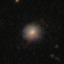

In [6]:
Image('/content/drive/MyDrive/genrated/fake_image_1.png')


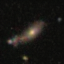

In [7]:
Image('/content/drive/MyDrive/genrated/fake_image_5.png')

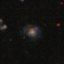

In [8]:
Image('/content/drive/MyDrive/genrated/fake_image_10.png')

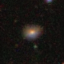

In [11]:
Image('/content/drive/MyDrive/genrated/fake_image_15.png')

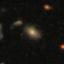

In [12]:
Image('/content/drive/MyDrive/genrated/fake_image_20.png')

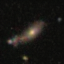

In [13]:
Image('/content/drive/MyDrive/genrated/fake_image_25.png')

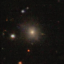

In [25]:
Image('/content/drive/MyDrive/genrated/fake_image_29.png')

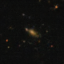

In [15]:
Image('/content/drive/MyDrive/genrated/fake_image_35.png')

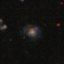

In [16]:
Image('/content/drive/MyDrive/genrated/fake_image_40.png')

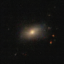

In [23]:
Image('/content/drive/MyDrive/genrated/fake_image_44.png')

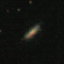

In [18]:
Image('/content/drive/MyDrive/genrated/fake_image_50.png')

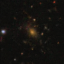

In [22]:
Image('/content/drive/MyDrive/genrated/fake_image_56.png')

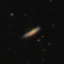

In [20]:
Image('/content/drive/MyDrive/genrated/fake_image_60.png')

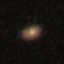

In [21]:
Image('/content/drive/MyDrive/genrated/fake_image_64.png')

# Losses

- We can also visualize how the loss changes over time. Visualizing losses is quite useful for debugging the training process. For GANs, we expect the generator's loss to reduce over time, without the discriminator's loss getting too high.

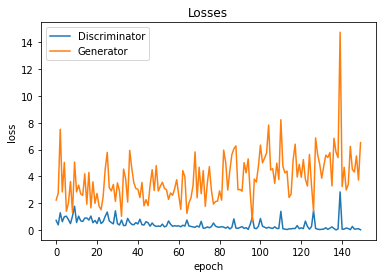

In [ ]:
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

- The generator's losses changed almost over every epoch. Where the generator loss drops lower than the discriminator loss (showing the generator fooled the discriminator), the discriminator quickly learns and in the next epoch correctly classifies the image as fake. 

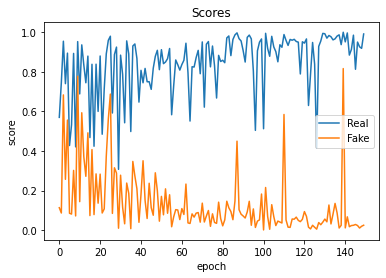

In [ ]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores');

- We can observe from the above that real images were achieved where the values are close to 1.0 while the values close to 0 depict fake images. 